Ce fichier a pour but de vérifer la qualité du modèle.  
Nous allons comparer l'évolution des performances du modèle sur une année.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import joblib

# Clustering
from sklearn.metrics import adjusted_rand_score, pair_confusion_matrix
from sklearn.preprocessing import StandardScaler
import plotly.express as px

from fonctions import *
from clustering_utils import *

In [2]:
# Import files
rfm = joblib.load("rfm_review_deliv_delay_dataset")
data = joblib.load("data_")

In [3]:
 # Calcul du délai de livraison
data["delivery_delay"] = data.order_delivered_customer_date - data.order_purchase_timestamp

In [4]:
# Instantiate a KMeans clustering model
model = KMeans(n_clusters=6, random_state=42)
model.fit(rfm)

# Assign each customer to a cluster
rfm_clustered = rfm.copy()
rfm_clustered['cluster_kmeans'] = model.predict(rfm)

#### Analyse de la stabilité

Je cherche ici, à observer l'évolution de la segmentation client au cours du temps. <br>

Pour cela, dans un premier temps, je découpe mon dataset:
- La première année servira d'entrainement pour mon K-Means,
- Je prédirai sur chaque mois suivant le nouvel état des clients.

Finalement, j'observerai cette évolution en calculant l'ARI score entre la première année et chaque mois suivants. <br>

##### **Décomposition dataset**

In [5]:
data.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'order_id', 'order_item_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'customer_total_commands',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_delivered_delay', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'delivery_delay'],
      dtype='object')

In [6]:
print(data.order_approved_at.min())
print(data.order_approved_at.max())

2016-10-04 09:43:32
2018-09-03 17:40:06


Ma période d'étude va du 4 Octobre 2016 au 3 Septembre 2018.
Je prends la période du 4 octobre 2016 au 31 décembre 2017 pour l'entrainement, soit un peu plus d'un an.

In [7]:
min_date = datetime(2016,10,4)
max_date = datetime(2018,1,1)

df_year_1 = data[data.order_approved_at < max_date]

In [8]:
df_months = {} 

for months in range(1, 9):
    max_date = datetime(2018, months+1, 1)
    df_months[f'df_months_{months}'] = data[ (data.order_approved_at >= min_date) & (data.order_approved_at < max_date)]


In [9]:
def create_kpis(data: pd.DataFrame):
    
    # Récence
    debut = datetime(2017,1,1,0,0,0)
    fin = datetime(2018,8,26,23,59,59)

    tmp = data.copy()

    tmp.drop_duplicates(subset='order_id', inplace=True) # J'ai plusieurs fois le même order_id si le client a commandé plusieurs produits
    tmp.set_index('order_id', inplace=True)
    tmp = tmp[['customer_unique_id', 'order_approved_at']]

    customer_recence = fin - tmp.groupby('customer_unique_id').max()['order_approved_at']
    customer_recence = customer_recence.apply(func=lambda x: x.days) # Je ne conserve que les jours

    # Fréquence

    tmp = data.copy()

    tmp.drop_duplicates(subset='order_id', inplace=True) # J'ai plusieurs fois le même order_id si le client a commandé plusieurs produits
    tmp.set_index('order_id', inplace=True)
    tmp = tmp[['customer_unique_id', 'order_approved_at']]

    customer_frequence = tmp.groupby('customer_unique_id').count()['order_approved_at']

    # Montant

    tmp = data.copy()

    tmp.drop_duplicates(subset='order_id', inplace=True) # J'ai plusieurs fois le même order_id si le client a commandé plusieurs produits
    tmp.set_index('order_id', inplace=True)
    tmp = tmp[['customer_unique_id', 'price']]

    customer_montant = tmp.groupby('customer_unique_id').sum()['price']
    
    # Delivery

    tmp = data.copy()
    tmp = data.copy()
    tmp.drop_duplicates(subset='order_id', inplace=True) # J'ai plusieurs fois le même order_id si le client a commandé plusieurs produits
    tmp.set_index('order_id', inplace=True)
    tmp["delay_in_seconds"] = tmp.delivery_delay.dt.total_seconds()
    tmp = tmp[['customer_unique_id', 'delay_in_seconds']]

    delivery = tmp.groupby('customer_unique_id').mean()['delay_in_seconds']

    # Review Score

    tmp = data.copy()

    tmp.drop_duplicates(subset='order_id', inplace=True) # J'ai plusieurs fois le même order_id si le client a commandé plusieurs produits
    tmp.set_index('order_id', inplace=True)
    tmp = tmp[['customer_unique_id', 'review_score']]

    review_score = tmp.groupby('customer_unique_id').mean()['review_score']

    # Création du DF
    kpi_df = pd.DataFrame(data={
                    'recence': customer_recence, 'frequence':customer_frequence, "montant":customer_montant
                    , "delivery_delay":delivery
                    , "review_score":review_score}, 
             )
    
    return kpi_df

def preproc_kpis(data: pd.DataFrame):
    tmp = data.copy()

    # Scaling
    scaler = StandardScaler()
    scaler.fit(tmp) 
    scaled_values = scaler.transform(tmp)

    return pd.DataFrame(data=scaled_values, columns=tmp.columns, index=tmp.index)

In [10]:
# Clients marqués comme outliers précédemment 

kpi_year_1 = preproc_kpis(create_kpis(df_year_1))
kpi_year_1.dropna(inplace=True)
                        
kpi_months = {}
for months in range(1,9):
    kpi_months[f'kpi_months_{months}'] = preproc_kpis(create_kpis(df_months[f'df_months_{months}'])) # On recalcule les KPIs pour ce dataset

##### **Calcul des ARIs**

In [11]:
df_month = kpi_months['kpi_months_2']
df_month = df_month.fillna(df_month.mean())
kmeans_month = KMeans(n_clusters=6, random_state=42)
kmeans_month.fit(df_month)
labels_true = kmeans_month.labels_

labels_pred = model.predict(df_month)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- delivery_delay
- frequence
- montant
- recence
- review_score
Feature names seen at fit time, yet now missing:
- Delivery
- Frequency
- MonetaryValue
- Recency
- Review

  warnings.warn(message, FutureWarning)


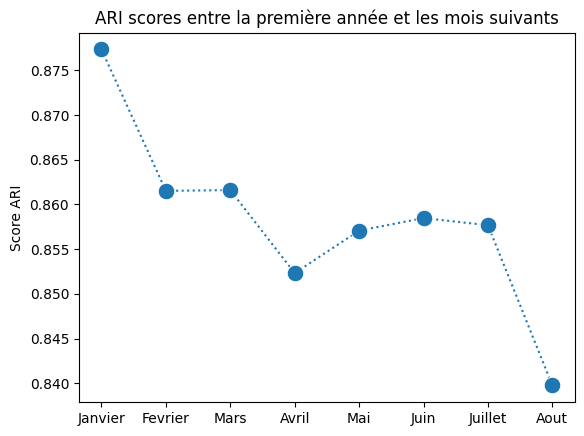

In [12]:
aris = []
kpi_year_1.sort_values(by='customer_unique_id', inplace=True)
model = KMeans(n_clusters=5, random_state=42)
model.fit(kpi_year_1)

# On compare les même clients
for months in range(1,9):
    
    df_month = kpi_months[f'kpi_months_{months}']
    df_month = df_month.fillna(df_month.mean())
    kmeans_month = KMeans(n_clusters=6, random_state=42)
    kmeans_month.fit(df_month)
    labels_true = kmeans_month.labels_

    labels_pred = model.predict(df_month)
    aris.append(adjusted_rand_score(labels_true, labels_pred))

x_index = ['Janvier', 'Fevrier', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout']

sns.lineplot(x=x_index, y=aris, linestyle='dotted', marker='o', markersize=12)

plt.ylabel('Score ARI')
plt.title('ARI scores entre la première année et les mois suivants')
plt.show()

On peut réentrainer le modèle en aout parce qu'on a un décrochage. Soit au bout de M+8